# Spectrogram of noise

In [3]:
import numpy as np 
import torch 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.mixture import GaussianMixture 
from pathlib import Path
import torchaudio 

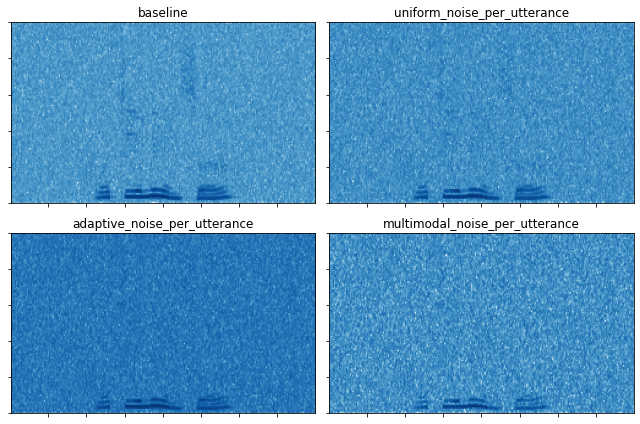

In [35]:
def add_noise(a, setting="uniform"):
    # a: 1-d torch.tensor (T,)
    torch.manual_seed(0)
    if setting == "baseline":
        return a 
    elif setting == "uniform_noise_per_utterance":
        n = torch.normal(mean=torch.zeros_like(a), std=torch.tensor(0.01))
        return a+n 
    elif setting == "adaptive_noise_per_utterance":
        scaling_factor = 0.1
        n = torch.normal(mean=torch.zeros_like(a), std=torch.tensor(scaling_factor) * torch.std(a))
        return a+n 
    elif setting == "multimodal_noise_per_utterance":
        n_components = 3
        scaling_factor = 0.1 
        gmm = GaussianMixture(n_components=n_components)
        gmm.fit(a.reshape(-1, 1))
        a_ = a 
        for c in range(n_components):
            a_ += gmm.weights_[c] * torch.normal(
                mean=-torch.ones_like(a) * gmm.means_[c, 0],
                std=torch.tensor(np.sqrt(gmm.covariances_[c][0, 0]))
            )
        return a_ 
    else:
        raise ValueError

def main():
    audio_path = "../data/LibriSpeech/dev-clean/84/121123/84-121123-0007.flac"
    a, sr = torchaudio.load(audio_path, channels_first=False)

    fig, axs = plt.subplots(2, 2, figsize=(9,6), sharex=True, sharey=True)

    indices = [(0,0), (0,1), (1,0), (1,1)]
    settings = ["baseline", "uniform_noise_per_utterance", 
        "adaptive_noise_per_utterance", "multimodal_noise_per_utterance"]
    for idx, setting in zip(indices, settings):
        x = add_noise(a, "multimodal_noise_per_utterance")
        axs[idx].specgram(x.numpy().reshape(-1), cmap=plt.get_cmap("Blues"))
        axs[idx].set_title(setting)
        axs[idx].set_xticklabels(labels=[])
        axs[idx].set_yticklabels(labels=[])

    plt.tight_layout()
    plt.savefig("spectrograms_84-121123-0007.svg")
    plt.show()

main()